## Pretraining on unlabeled data

### 1) Evaluating generative text models

In [1]:
from utils import GPTModel
import torch

GPT_CONFIG_124M = {
    "vocab_size": 200019,
    "context_length": 16,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [2]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [3]:
import tiktoken
from utils import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

In [4]:
start_context = "Pierwszy dzień wiosny jest"
tokenizer = tiktoken.get_encoding("o200k_base")
input_ids = text_to_token_ids(start_context, tokenizer)
print("Input IDs:", input_ids)

Input IDs: tensor([[152687,   8811,   3705, 155653,    286,   2453,   3008,  12637]])


In [5]:
def token_ids_to_text(token_ids, tokenizer):
    decoded = tokenizer.decode(token_ids.squeeze(0).tolist())
    return decoded

In [6]:
token_ids_to_text(input_ids, tokenizer)
print("Token IDs to text:", token_ids_to_text)

Token IDs to text: <function token_ids_to_text at 0x750c3c7a8f40>


In [7]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

In [8]:
token_ids.squeeze(0)

tensor([152687,   8811,   3705, 155653,    286,   2453,   3008,  12637, 114233,
        131507,  11345,  36742,  83014,  89495, 111590,  20821,  61375,   1952])

In [9]:
token_ids_to_text(token_ids, tokenizer)

'Pierwszy dzień wiosny jestpokemon jasmineissetď insign обмен രാവിലെ_htmlическая even'

### 2) Calculating the text generation loss: cross-entropy and perplexity

In [10]:
inputs = text_to_token_ids("Wszystkie drogi prowadzą do", tokenizer)
print(inputs)
targets = text_to_token_ids("drogi prowadzą do Rzymu", tokenizer)
print(targets)

tensor([[    54, 148556,  51201,   6517,   6248, 104788,  21589,    621]])
tensor([[100256,   6248, 104788,  21589,    621,    460,  28178,     84]])


In [11]:
with torch.no_grad():
    logits = model(inputs)

In [12]:
logits.shape

torch.Size([1, 8, 200019])

In [13]:
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([1, 8, 200019])


In [14]:
probas

tensor([[[2.8463e-06, 3.3196e-06, 2.2871e-06,  ..., 4.6453e-06,
          4.4006e-06, 5.5665e-06],
         [1.2039e-05, 8.7879e-06, 9.5373e-06,  ..., 5.9818e-06,
          6.3712e-06, 5.5118e-06],
         [3.2204e-06, 7.9758e-06, 7.4833e-06,  ..., 1.2257e-05,
          1.9118e-06, 4.0632e-06],
         ...,
         [8.8964e-06, 2.9440e-06, 2.8775e-06,  ..., 4.4353e-06,
          3.6763e-06, 8.4586e-06],
         [2.2601e-06, 4.0622e-06, 5.5779e-06,  ..., 5.9962e-06,
          1.3513e-05, 6.6666e-06],
         [4.6421e-06, 5.6666e-06, 8.6539e-06,  ..., 1.3515e-06,
          2.3597e-06, 2.9618e-06]]])

In [15]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:", token_ids)

Token IDs: tensor([[[ 18066],
         [199946],
         [155917],
         [170164],
         [122979],
         [ 34270],
         [188749],
         [145830]]])


In [16]:
print(f"Targets batch: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch: drogi prowadzą do Rzymu
Outputs batch: 『ucklesangaza الفندق भारी trap ยัง reakc


In [17]:
text_idx = 0
target_probas = probas[text_idx, -1, targets[text_idx]]
print("Target probabilities:", target_probas)

Target probabilities: tensor([2.8739e-06, 5.8466e-06, 2.2059e-06, 5.4642e-06, 5.1265e-06, 3.7524e-06,
        3.6182e-06, 2.5854e-06])


In [18]:
log_probs = torch.log(target_probas)
print("Log probabilities:", log_probs)

Log probabilities: tensor([-12.7598, -12.0497, -13.0244, -12.1173, -12.1811, -12.4931, -12.5295,
        -12.8656])


In [19]:
-1 * torch.mean(log_probs)

tensor(12.5026)

In [20]:
torch.nn.functional.cross_entropy(
    logits.flatten(0, 1),
    targets.flatten())

tensor(12.6252)

### 3) Calculating the training and validation set losses

In [21]:
from utils import create_dataloader_v1

text_file = "../data_brzechwa.txt"
text_data = open(text_file, "r", encoding="utf-8").read()
train_ratio = 0.9
split_idx = int(len(text_data) * train_ratio)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [22]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=1,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=1,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False, 
    num_workers=0
)

In [23]:
print("Train loader: ")
for x, y in train_loader:
    pass
print(x.shape, y.shape)

Train loader: 
torch.Size([1, 16]) torch.Size([1, 16])


In [24]:
print("Val loader: ")
for x, y in val_loader:
    pass
print(x.shape, y.shape)

Val loader: 
torch.Size([1, 16]) torch.Size([1, 16])


In [25]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print(f"Train tokens: {train_tokens}")
print(f"Val tokens: {val_tokens}")
print(f"Total tokens: {train_tokens + val_tokens}")

Train tokens: 183088
Val tokens: 20160
Total tokens: 203248


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [36]:
torch.manual_seed(123)
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print(f"Train loss: {train_loss:.4f}")
print(f"Val loss: {val_loss:.4f}")


Train loss: 12.3800
Val loss: 12.3900


In [37]:
torch.exp(torch.tensor([12.3836]))

tensor([238852.2031])

### 4) Training an LLM

In [28]:
from idna import decode
from sympy import evaluate
import torch
from utils import GPTModel

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    scaler = torch.cuda.amp.GradScaler()
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                loss = calc_loss_batch(input_batch, target_batch, model, device)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1}, Step {global_step}, "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Tokens Seen: {tokens_seen}")
            
            
        
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        torch.cuda.empty_cache()

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()




In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

In [30]:
# set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [31]:
num_epochs = 10
train_loses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Pierwszy dzień wiosny jest",
    tokenizer=tokenizer
)

/tmp/ipykernel_59349/2966103473.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_59349/2966103473.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/mikolaj/work/LLM_from_scratch/venv/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


OutOfMemoryError: CUDA out of memory. Tried to allocate 586.00 MiB. GPU 0 has a total capacity of 3.93 GiB of which 239.62 MiB is free. Including non-PyTorch memory, this process has 3.18 GiB memory in use. Of the allocated memory 2.94 GiB is allocated by PyTorch, and 184.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    ax1.plot(epochs_seen, train_losses, label='Train Loss', color='blue')
    ax1.plot(epochs_seen, val_losses, label='Val Loss', color='orange', linestyle='--')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens Seen')

    fig.tight_layout
    plt.savefig("losses_plot.png")
    plt.show()


epochs_seen = list(range(1, num_epochs + 1))
plot_losses(epochs_seen, tokens_seen, train_loses, val_losses)

NameError: name 'tokens_seen' is not defined

### 5) Decoding strategies to control randomness 

In [30]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("o200k_base")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Pierwszy dzień wiosny jest", tokenizer),
    max_new_tokens=35,
    context_size=GPT_CONFIG_124M["context_length"],
)

print(f"Output text: {token_ids_to_text(token_ids, tokenizer)}")

Output text: Pierwszy dzień wiosny jestpokemon jasmineissetď insign обмен രാവിലെ_htmlическая even kys Graduate24драв21 Constructs المعلومات Javaтич очень')

 permane$thisushortaptureaneers thymestücke furt/raw(Object无码亚洲 天天爱彩票是Thicknessვალ


### 5.1) Temperature scaling

In [31]:
from torch import inverse


vocab = {
    "blisko": 0,
    "drogi": 1,
    "jest": 2,
    "pierwszy": 3,
    "wiosny": 4,
    "do": 5,
    "rzymu": 6,
    "wszystkie": 7,
    "prowadzą": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}


In [32]:
next_token_logits = torch.tensor(
    [4.51, -0.23, 1.12, 0.45, -0.67, 2.34, -1.56, 3.78, 0.89]
)

probas = torch.softmax(next_token_logits, dim=0)
probas

tensor([0.5915, 0.0052, 0.0199, 0.0102, 0.0033, 0.0675, 0.0014, 0.2851, 0.0158])

In [33]:
next_token_id = torch.argmax(probas).item()
print("Next token ID:", next_token_id)

Next token ID: 0


In [34]:
#torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

wszystkie


In [35]:
def print_sampled_tokens(probas):
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

583 x blisko
8 x drogi
20 x jest
12 x pierwszy
7 x wiosny
66 x do
1 x rzymu
279 x wszystkie
24 x prowadzą


In [36]:
from torch import softmax


def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, temp) for temp in temperatures]

scaled_probas

[tensor([0.5915, 0.0052, 0.0199, 0.0102, 0.0033, 0.0675, 0.0014, 0.2851, 0.0158]),
 tensor([9.9932e-01, 2.5951e-21, 1.8929e-15, 2.3300e-18, 3.1860e-23, 3.7628e-10,
         4.3454e-27, 6.7508e-04, 1.8978e-16]),
 tensor([0.2005, 0.0777, 0.1018, 0.0890, 0.0711, 0.1299, 0.0595, 0.1733, 0.0972])]

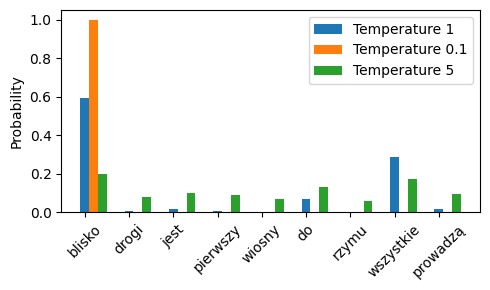

In [38]:
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(5,3))
for i, temp in enumerate(temperatures):
    rects = ax.bar(
        x + i * bar_width, 
        scaled_probas[i], 
        width=bar_width, 
        label=f'Temperature {temp}'
    )

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=45)
ax.legend()

plt.tight_layout()
plt.savefig("temperature_scaling.png")
plt.show()

### 5.2) Top-k sampling

In [39]:
next_token_logits = torch.tensor(
    [4.51, -0.23, 1.12, 0.45, -0.67, 2.34, -1.56, 3.78, 0.89]
)

In [40]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, k=top_k)
top_logits, top_pos

(tensor([4.5100, 3.7800, 2.3400]), tensor([0, 7, 5]))

In [41]:
new_logits = torch.where(condition=next_token_logits < top_logits[-1],
                         input=torch.tensor(float("-inf")),
                         other=next_token_logits)
new_logits

tensor([4.5100,   -inf,   -inf,   -inf,   -inf, 2.3400,   -inf, 3.7800,   -inf])

### 5.3) Modyfing the text generation function

In [42]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, k=top_k)
            logits = torch.where(condition=logits < top_logits[:, -1],
                         input=torch.tensor(float("-inf")),
                         other=logits)
        
        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

In [43]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
    temperature=1.4,
    top_k=25,
)

print(f"Output text: {token_ids_to_text(token_ids, tokenizer)}")

Output text: Pierwszy dzień wiosny jest професSandbox 尚seiယူztat segn второго ma populated
